# 'emPPCA' examples

In [2]:
from emPPCA import emPPCA

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from natsort import index_natsorted

---

### Tobomovirus datset
We synthetically set four replicates of different degree of perturbation, as well as different missing structures. \
One may see in the variance plot that indeed the unexplained variance follows the degree of perturbation.

In [10]:
# Dataframe loading
virus = pd.read_csv('tobomovirus/virus3.txt', delimiter='\s+', header=None).values

# Synthetic replicates of different perturbation
np.random.seed(123)
R = 4
name_rep = []
virus_rep = []
scale = 3 / (R-1)
for r in range(R):
    current_rep = virus + np.random.normal(loc=0.0, scale=scale * r, size=virus.shape)
    mask = np.random.choice([True, False], size=virus.shape, p=[0.2, 0.8]) # Each entry missing at probability of 20%
    current_rep = np.where(mask, np.nan, current_rep)
    virus_rep.append(current_rep)

In [11]:
# Create model instance
scaler = StandardScaler()
Y = [scaler.fit_transform(df) for df in virus_rep]
tobomovirus = emPPCA(Y, q=2)
tobomovirus.fit()

EM algorithm converged with 19 iterations; with relative change 8.805092916182256e-07.


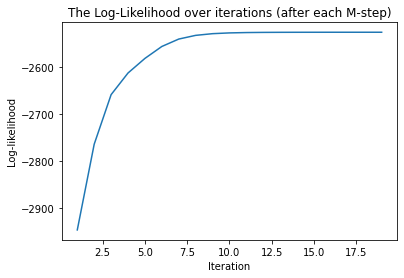

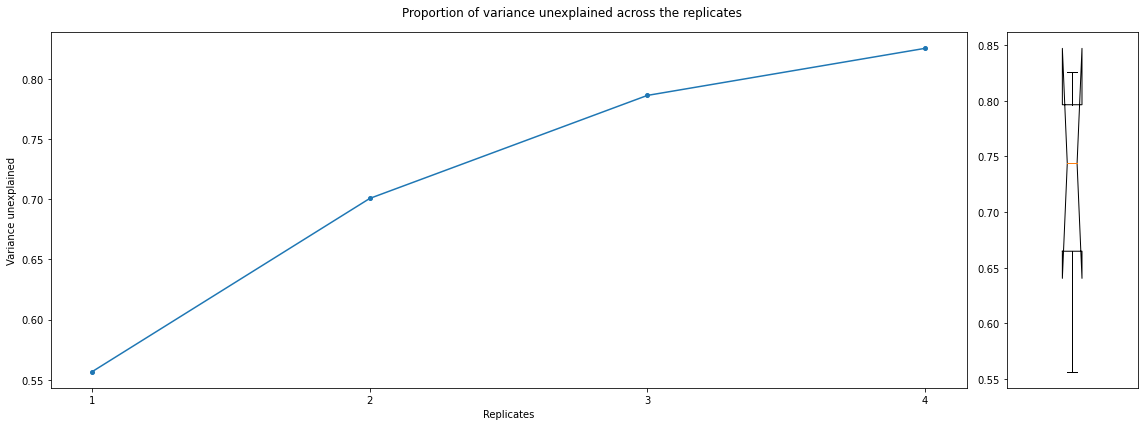

In [15]:
tobomovirus.ll_plot('pSCoPE_ll_plot')
tobomovirus.var_plot('pSCoPE_var_plot')

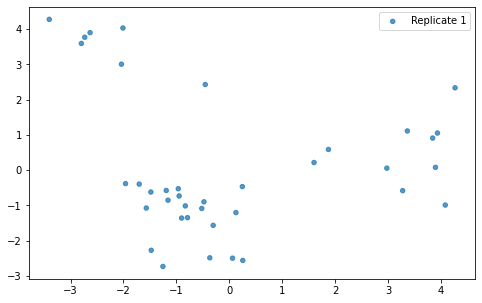

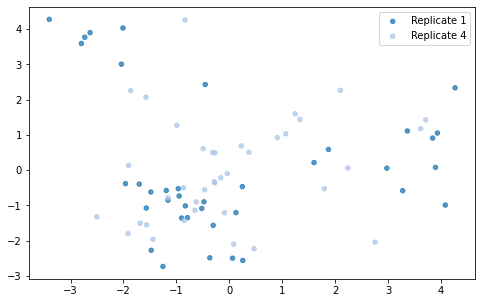

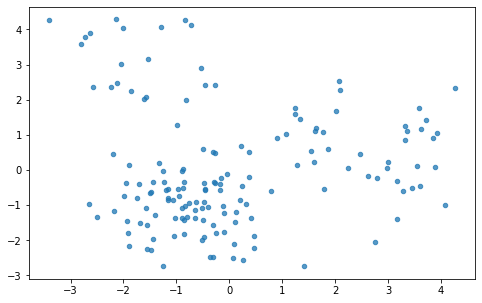

In [16]:
tobomovirus.X_plot(compare='replicate', reps=[1], name='tobomovirus_X_plot_1')
tobomovirus.X_plot(compare='replicate', reps=[1,4], name='tobomovirus_X_plot_2')
tobomovirus.X_plot(compare='class', reps=list(range(R)), name='tobomovirus_X_plot_3')
# As there are no classes specified, compare classes will give the figure without legends

### pSCoPE Fig.4a [1]

In [17]:
# Dataframe loading
data = pd.read_csv('pSCoPE/processed.csv',index_col=0).T
guide = pd.read_csv('pSCoPE/guide.csv',index_col=0)
guide = guide[guide.index.isin(data.index)]

# Dataset reformulation
id_rep = [] 
label_rep = [] 
Y_rep = [] 
R = 40 
for i in range(R):
    id_rep.append(guide[guide['Raw.file'] == f'XwGH05{i:02d}'].index)
    label_rep.append(guide.loc[id_rep[i]]['celltype'].tolist())
    Y_rep.append(data.loc[id_rep[i]])

# Text labels and color labels
label = [label_rep[i] for i in range(R)]
color_dict = {'untreated': 0, 'LPS': 1}
col = [[color_dict[i] for i in label[r]] for r in range(R)] 

In [19]:
# Create model instance
scaler = StandardScaler()
Y = [scaler.fit_transform(df) for df in Y_rep]
pSCoPE = emPPCA(Y, q=2, textlabel=label_rep, label=col)
pSCoPE.fit()

EM algorithm converged with 205 iterations; with relative change 9.728450424794936e-07.


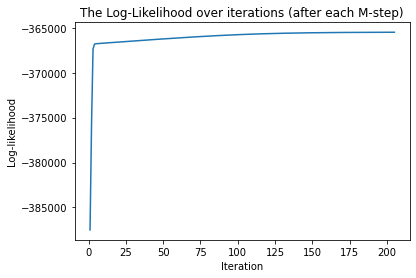

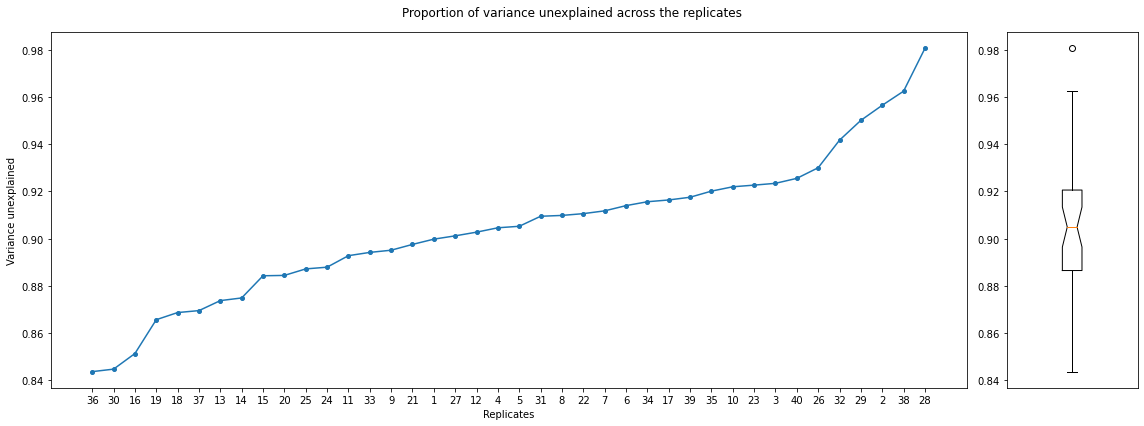

In [20]:
pSCoPE.ll_plot('pSCoPE_ll_plot')
pSCoPE.var_plot('pSCoPE_var_plot')

We have identified that replicates with number $28,38,2,29,32$ have higher proportion of variance unexplained (particularly replicate $28$). <br/>
So it might be necessary for researchers to have a check for the experiments related to these replicates. <br/>
After identifying some potential explanation for this, one may consider to exclude these replicates from the usage of PCA/PPCA; Because these observations are relatively not explained well by the model, and thus the low-dimensional representations may give information more different from the full feature observations.

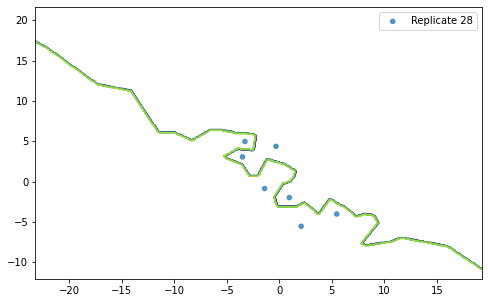

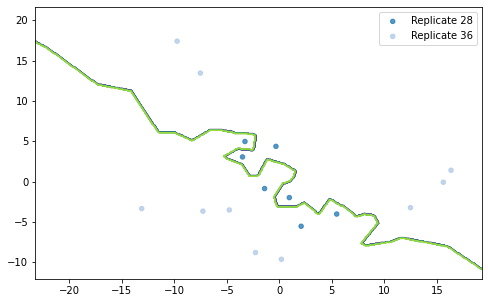

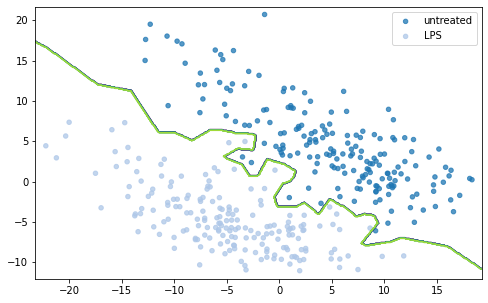

In [21]:
pSCoPE.X_plot(compare='replicate', reps=[28], name='pSCoPE_X_plot_1')
pSCoPE.X_plot(compare='replicate', reps=[28,36], name='pSCoPE_X_plot_2')
pSCoPE.X_plot(compare='class', reps=list(range(R)), name='pSCoPE_X_plot_3')

---
### plexDIA Fig.6p [2]

There were two instruments used: 'Q-Exactive' and 'timsTOFSCP' which can be considered naturally as a pair of replicates. <br/>
Moreover, observations measured by Q Exactive have different digest types, 'A' and 'B'; This could mean a replicate variation in digestion into peptides. <br/>
Hence there are 3 replicates:
1. 'QE_A', id1-id144
2. 'QE_B', id145-id153 
3. 'timsTOFSCP', id154-id186

In [24]:
R = 3

# Dataframe loading (164 observations in total)
df = pd.read_csv('plexDIA/Proteins_SC_IDs.txt', sep='\s+')
df = df.drop(columns=['prot']).T
df = df.iloc[index_natsorted(df.index)]
guide = pd.read_csv('plexDIA/Meta_SC.tsv', sep='\s+', index_col=0)
guide = guide.set_index('id')
guide = guide.iloc[index_natsorted(guide.index)]
guide = guide[guide.index.isin(df.index)]

# Replicate 1
QE_A_id = list(guide[(guide['Instrument']=='Q-Exactive') & (guide['Digest']=='A')].index)
# Replicate 2    
QE_B_id = list(guide[(guide['Instrument']=='Q-Exactive') & (guide['Digest']=='B')].index)
# Replicate 3
timsTOFSCP_id = list(guide[(guide['Instrument']=='timsTOFSCP')].index)

# Text labels
textlabel = [list(guide.loc[QE_A_id]['Celltype'])]
textlabel.append([i.replace('_DB','') for i in list(guide.loc[QE_B_id]['Celltype'])])
textlabel.append([i.replace('_t','') for i in list(guide.loc[timsTOFSCP_id]['Celltype'])])
# Labels
color_dict = {'Melanoma': 0, 'PDAC': 1, 'U-937': 2}
label = [[color_dict[i] for i in textlabel[r]] for r in range(R)] 

# Formated list Y
Y_rep = [df.loc[QE_A_id].values, df.loc[QE_B_id].values, df.loc[timsTOFSCP_id].values]

In [25]:
# Create model instance
scaler = StandardScaler()
Y = [StandardScaler().fit_transform(rep) for rep in Y_rep]
plexDIA = emPPCA(Y, q=2, textlabel=textlabel, label=label)
plexDIA.fit(max_iter=2000)

EM algorithm converged with 1203 iterations; with relative change 9.997760230747857e-07.


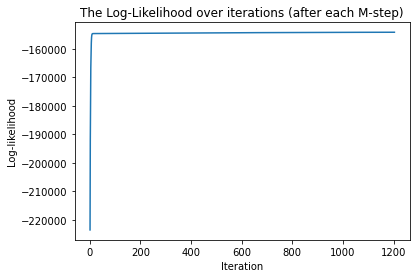

In [26]:
plexDIA.ll_plot(name='plexDIA_ll_plot')

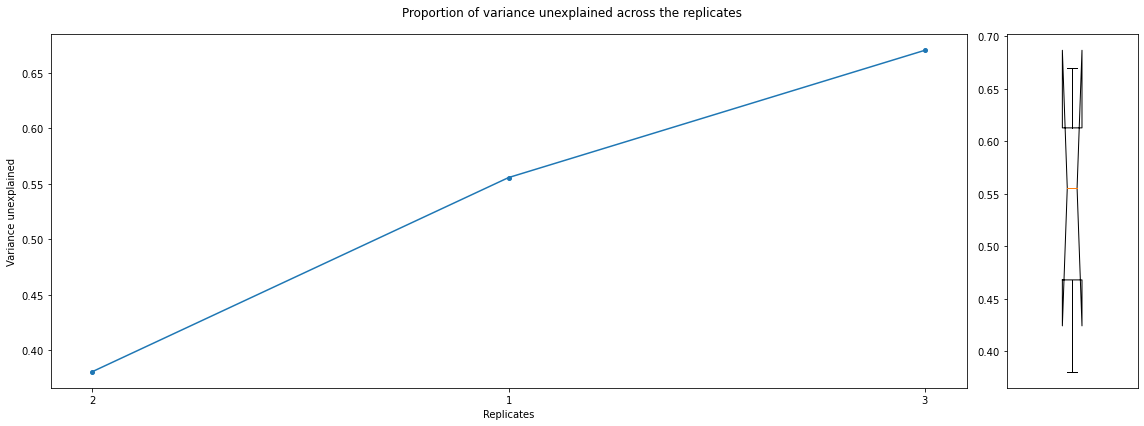

In [27]:
plexDIA.var_plot(name='plexDIA_var_plot')

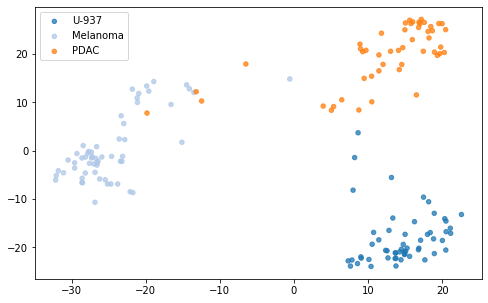

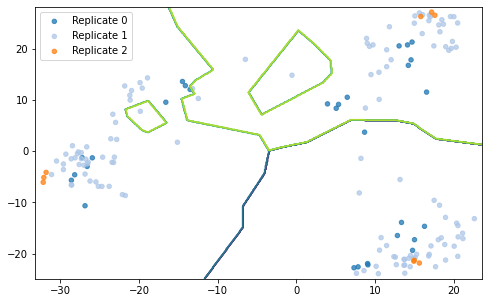

In [28]:
plexDIA.X_plot(compare='class', NN=False, name='plexDIA_X_plot_1')
plexDIA.X_plot(compare='replicate', NN=True, name='plexDIA_X_plot_2')

---
### 

---

### References

###### [1] &nbsp; Huffman, R. G., Leduc, A., Wichmann, C., Di Gioia, M., Borriello, F., Specht, H., ... & Slavov, N. (2023). Prioritized mass spectrometry increases the depth, sensitivity and data completeness of single-cell proteomics. Nature methods, 20(5), 714-722.

###### [2] &nbsp; Derks, J., Leduc, A., Wallmann, G., Huffman, R. G., Willetts, M., Khan, S., ... & Slavov, N. (2023). Increasing the throughput of sensitive proteomics by plexDIA. Nature biotechnology, 41(1), 50-59.